# Mauricio Amoni

## Content

* [Introduction](#introduction)
* [Importing Libraries](#importing)
* [Pre-processing Data](#preprocessing)
  * [Reading Data Set using Pandas](#reading)
  * [Adding new columns & Cheking Data Set](#adding) 
* [Classification Models](#classification)
  * [Error Analysis](#error)
  * [Building Two Models](#two)
  * [Building a model for each interval](#each)
* [Regression](#regression)
* [Conclusions](#conclusions)


  

## Introduction<a class='anchor' id='introduction'></a>

This report is part of the ongoing project for Credit One. The main goal of the project is to identify which customer attributes relate significantly to customer default rates and to build a predictive model that can be used to better classify potential customers as being 'at-risk'. It would be interesting to also establish a model to understand wich quantity is the most suitable for each client and try to establish a model to identify potential good clients (revolving credit). 

After having carried out an exploration of the existing data in order to better understand it, the goal of this report is to build the prediction models to lower the default rates. The report begins with the classification models to try to identify potential customers as being 'at-risk', and later potentially good customers (revolving credit). The report then tries to establish a model via regression to understand wich quantity is the most suitable for each client.

&nbsp;

## Importing Libraries<a class='anchor' id='importing'></a>

In [1]:
# Importing 
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import numpy as np
from numpy import argmax
from math import sqrt
import seaborn as sns


#SKLearn
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *

## Pre-processing Data<a class='anchor' id='preprocessing'></a>

#### Reading Data Set using Pandas<a class='anchor' id='reading'></a>

In [2]:
data = pd.read_csv('credit_one_final.csv')

#### Adding new columns & Cheking Data Set<a class='anchor' id='adding'></a>

In [3]:
# Creates a new column by binning the age of the customers
data['AGE_BINNED'] = pd.cut(data['AGE'], bins=[21,31,41,51,61,71,81], 
                    labels=['21-31', '31-41', '41-51', '51-61', '61-71', '71-81'])


In [4]:
# Creates a new column by binning the Limit Balance variable
data['BAL_BINNED'] = pd.cut(data['LIMIT_BAL'], bins=[5000,50000,100000,150000,200000,250000,300000,400000,500000,1000000],
labels=['(5000, 50000]','(50000, 100000]','(100000, 150000]',
        '(150000, 200000]','(250000, 300000]','(200000, 250000]',
        '(300000, 400000]','(400000, 500000]', ('+500000')])


In [5]:
# Creates a new column by binning the age of the customers

In [6]:
# Creates a new column name 'BAL DIF' subtracting the column with maximum amount billed 
# from among all amount billed columns and the limit balance column
data['BAL_DIF'] = (data[['SEP_BILL1','AUG_BILL2','JUL_BILL3','JUN_BILL4','MAY_BILL5','APR_BILL6']].max(axis=1))-data['LIMIT_BAL']

In [7]:
# Information about the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30201 entries, 0 to 30200
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   ID                         30201 non-null  int64   
 1   LIMIT_BAL                  30201 non-null  int64   
 2   MARRIAGE                   30201 non-null  int64   
 3   AGE                        30201 non-null  int64   
 4   SEP_PAY1                   30201 non-null  int64   
 5   AUG_PAY2                   30201 non-null  int64   
 6   JUL_PAY3                   30201 non-null  int64   
 7   JUN_PAY4                   30201 non-null  int64   
 8   MAY_PAY5                   30201 non-null  int64   
 9   APR_PAY6                   30201 non-null  int64   
 10  SEP_BILL1                  30201 non-null  int64   
 11  AUG_BILL2                  30201 non-null  int64   
 12  JUL_BILL3                  30201 non-null  int64   
 13  JUN_BILL4                  3020

In [8]:
# Check the first 5 rows of the data frame
data.head()

,ID,LIMIT_BAL,MARRIAGE,AGE,SEP_PAY1,AUG_PAY2,JUL_PAY3,JUN_PAY4,MAY_PAY5,APR_PAY6,...,SEX_male,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,DEF_PAY_default,DEF_PAY_not default,AGE_BINNED,BAL_BINNED,BAL_DIF
0,1,20000,1,24,2,2,-1,-1,-2,-2,...,0,0,0,0,1,1,0,21-31,"(5000, 50000]",-16087
1,2,120000,2,26,-1,2,0,0,0,2,...,0,0,0,0,1,1,0,21-31,"(100000, 150000]",-116545
2,3,90000,2,34,0,0,0,0,0,0,...,0,0,0,0,1,0,1,31-41,"(50000, 100000]",-60761
3,4,50000,1,37,0,0,0,0,0,0,...,0,0,0,0,1,0,1,31-41,"(5000, 50000]",-709
4,5,50000,1,57,-1,0,-1,0,0,0,...,1,0,0,0,1,0,1,51-61,"(5000, 50000]",-14165


## Classification Models<a class='anchor' id='classification'></a>

In this part, as explained in the introduction, we try to identify potential customers who are at risk. To begin with, three models are built -Decision Tree, Random Forest, Gradient Boosting- to find the most appropriate model. To do this, cross validation is used for the three models : 

&nbsp;

In [9]:
# Selecting features
X = data[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]


In [10]:
# Selecting dependent variable
y = data['DEF_PAY_default']

In [11]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=123)

In [12]:
# Creates an array of models
algos_Class = []
algos_Class.append(('Random Forest Classifier:', RandomForestClassifier(max_depth=4)))
algos_Class.append(('Decision Tree Classifier:', DecisionTreeClassifier(max_depth=4)))
algos_Class.append(('Gradient Boosting Classifier:', GradientBoostingClassifier()))

In [13]:
# Loops across the array and uses the cross_val_score function for each model
results = []
names = []
feature_importance = []

for name,model in algos_Class:
        result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
        names.append(name)
        results.append(result)
        
        

In [14]:
# Prints the results of each model
for i in range(len(names)):
    print(names[i], results[i].mean())

Random Forest Classifier: 0.7787490480447667
Decision Tree Classifier: 0.7787490480447667
Gradient Boosting Classifier: 0.7785172676401443


&nbsp;

After seeing the results, quite similar. It is decided to continue with the Gradient Boosting model since boosting algorithms are ideal for imbalanced datasets. And as explained in the following <a href="https://repositorio.bde.es/handle/123456789/14691"> Bank of Spain document</a> , it seems that it obtains better results than the others.

So to obtain more information about the initial result, the model is built again and the classification report and the confusion matrix are printed:

&nbsp;

In [15]:
# Modelling(Classification)
algo = GradientBoostingClassifier()
model = algo.fit(X_train, y_train)

In [16]:
# Predictions,classification report and confusion matrix
preds = model.predict(X_test)
print(classification_report(y_test, preds))
print(pd.DataFrame(confusion_matrix(y_test, preds)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7047
           1       0.44      0.00      0.01      2014

    accuracy                           0.78      9061
   macro avg       0.61      0.50      0.44      9061
weighted avg       0.70      0.78      0.68      9061

      0  1
0  7038  9
1  2007  7


With more information it is clearly seen that despite having an accuracy of 0.78 this model is not capable of predicting the positive class, which represents the default. For this reason, it is convenient to decide which are the most appropriate metrics to decide the quality of the model.

In this case, as it is a business model based on giving credit to clients, it is appropriate to achieve the minimum possible default percentage. Taking into account that the current default rate is above 20%, the situation is far from optimal. For this reason, although it is desirable to obtain a model as accurate as possible, the priority will be to identify as many defaults as possible.

Before continuing tuning the model we observe which are the most important features : 

&nbsp;


<BarContainer object of 6 artists>

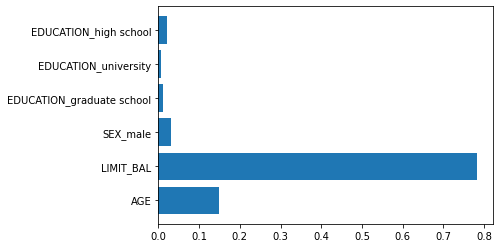

In [17]:
# Plots a horizontal graph with the variables used in the model and the feature_importances function
plt.barh(X.columns, model.feature_importances_)

It is clear that the most important variable for this model at the moment is the Limit Balance by far, followed by age.

Now we continue to fine-tune the model taking into account the need to detect the maximum possible number of defaults:

&nbsp;

In [18]:
# Selecting features
X = data[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

algo = GradientBoostingClassifier(learning_rate=0.05, n_estimators=501, max_depth=10, random_state=10) 
model = algo.fit(X_train, y_train)

# Predictions,classification report and confusion matrix
preds = model.predict(X_test)
print(classification_report(y_test, preds))
print(pd.DataFrame(confusion_matrix(y_test, preds)))

              precision    recall  f1-score   support

           0       0.78      0.92      0.85      7019
           1       0.33      0.13      0.18      2042

    accuracy                           0.74      9061
   macro avg       0.56      0.53      0.52      9061
weighted avg       0.68      0.74      0.70      9061

      0    1
0  6482  537
1  1782  260


In [19]:
# Selecting features
X = data[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.5, n_estimators=801, max_depth=10,subsample= 0.8, random_state=10)
model = algo.fit(X_train, y_train)

# Predictions,classification report and confusion matrix
preds = model.predict(X_test)
print(classification_report(y_test, preds))
print(pd.DataFrame(confusion_matrix(y_test, preds)))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      7019
           1       0.26      0.22      0.24      2042

    accuracy                           0.68      9061
   macro avg       0.52      0.52      0.52      9061
weighted avg       0.66      0.68      0.67      9061

      0     1
0  5734  1285
1  1596   446


With these two models it can be seen how the recall has been increased to 0.22 but even so the number of detected defaults is still very low as can be seen in the confusion matrix. A quick look at the TP and FP shows that the detection of the latest model is below a third of the total positives.

To try to continue improving the results, we will try to modify the threshold that the model uses by default to decide if a prediction is negative or positive. With which the next step tries to identify an optimal threshold to be applied:

&nbsp;

Best Threshold=0.214637


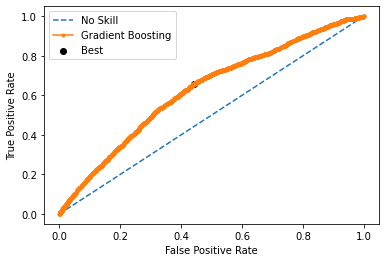

In [20]:
# Selecting features
X = data[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=124)

# Modelling(Classification)
algo = GradientBoostingClassifier()
model = algo.fit(X_train, y_train)

# Predicts probabilities and keep them for the positive outcome only
y_scores = model.predict_proba(X_test)[:,1]

# Calculates roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Gets the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

# Plots the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Gradient Boosting')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In this case, the roc curve of the model has been plotted and the optimal point between true and false positive rates has been sought. The result gives a threshold of 0.214.

To continue with an analysis of the best possible threshold, a precision-recall curve is plotted, which unlike the ROC-AUC focuses only on the positive class : 

&nbsp;

Best Threshold=0.226282, F-Score=0.404


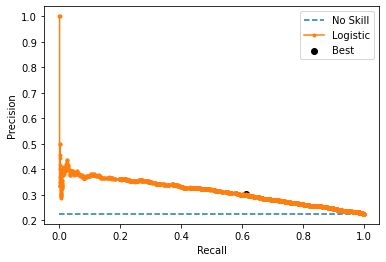

In [21]:
# Selecting features
X = data[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier()
model = algo.fit(X_train, y_train)

# Predicts probabilities and keep them for the positive outcome only
y_scores = model.predict_proba(X_test)[:,1]

# Calculates precision-recall curves
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Converts to f score
fscore = (2 * precision * recall) / (precision + recall)

# Locates the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# Plot the precision-recall curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In this case, it indicates that the best threshold is 0.226, a number quite similar to that given by the ROC-AUC.

With this information, the next step is to create a function that modifies the predictions based on the desired threshold. And later a function is created that plots the classifcation-report and the confusion matrix of a model taking as parameters a dataframe and a threshold. In this way, different variable names are incorporated into the function that can store different dataframes that may be of interest throughout the report.This function also incorporates some important information that must be taken into account when fine-tuning a model and modifying the threshold :

&nbsp;

In [22]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]


In [23]:
def classification_matrix_report(dataframe, t=0.5):
    """
    shows the classification report and the confusion matrix for each classifier
    by identifying the classifier's threshold(t).
    """
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    preds = adjusted_classes(y_scores, t)
    print(classification_report(y_test, preds))
    df = pd.DataFrame(confusion_matrix(y_test, preds),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos'])
    
   
    
    if (dataframe is data):
        total = df.sum().sum()
        marked_pos = np.round((df['pred_pos'].sum())/total*100,decimals=1)
        actual_pos = np.round(((df['pred_neg'][1]+df['pred_pos'][1])/total)*100,decimals=1)
        missed_pos = np.round((df['pred_neg'][1]/(df['pred_neg'][1]+df['pred_pos'][1]))*100,decimals=1)
        actual_pos = np.round((df['pred_pos'][1]/(df['pred_pos'][0]+df['pred_pos'][1]))*100,decimals=1)
        final_def_perc = np.round(((df['pred_neg'][1])/total)*100,decimals=1)
        cust_perc = 100-marked_pos
        print(df,'\n')
        print('Actual positives in the data set:{}%'.format(actual_pos))
        print('Marked as positive by the algorithm:{}%'.format(marked_pos))
        print('Actual positives inside the marked as positive: {}%'.format(actual_pos))
        print('Currently missed positives of the total actual positives: {}\n'.format(missed_pos))
        print('The final default rate after applying this algorithm could be: {}%'.format(final_def_perc))
        print('The number of customers would be reduced in comparison to the current number to a {}%'.format(cust_perc))
    
   
    elif dataframe is data2:
        total = df.sum().sum()
        marked_pos = np.round((df['pred_pos'].sum())/total*100,decimals=1)
        actual_pos = np.round(((df['pred_neg'][1]+df['pred_pos'][1])/total)*100,decimals=1)
        missed_pos = np.round((df['pred_neg'][1]/(df['pred_neg'][1]+df['pred_pos'][1]))*100,decimals=1)
        actual_pos2 = np.round((df['pred_pos'][1]/(df['pred_pos'][0]+df['pred_pos'][1]))*100,decimals=1)
        global final_def_perc2
        final_def_perc2 = np.round(((df['pred_neg'][1])/total)*100,decimals=1)
        data2_numb = len(data2)-(marked_pos*len(data2))/100
        global data2_perc 
        data2_perc = np.round(data2_numb/len(data2)*100,decimals=1)
        print(df,'\n')
        print('Actual positives in the data set:{}%'.format(actual_pos))
        print('Marked as positive by the algorithm:{}%'.format(marked_pos))
        print('Actual positives inside the marked as positive: {}%'.format(actual_pos2))
        print('Currently missed positives of the total actual positives: {}\n'.format(missed_pos))
        print('The final default rate after applying this algorithm could be: {}%'.format(final_def_perc2))
        print('The number of customers would be reduced in comparison to the current number to a {}%'.format(data2_perc))
    
    
    elif dataframe is data3:
        total = df.sum().sum()
        marked_pos = np.round((df['pred_pos'].sum())/total*100,decimals=1)
        actual_pos = np.round(((df['pred_neg'][1]+df['pred_pos'][1])/total)*100,decimals=1)
        missed_pos = np.round((df['pred_neg'][1]/(df['pred_neg'][1]+df['pred_pos'][1]))*100,decimals=1)
        actual_pos3 = np.round((df['pred_pos'][1]/(df['pred_pos'][0]+df['pred_pos'][1]))*100,decimals=1)
        global final_def_perc3
        final_def_perc3 = np.round(((df['pred_neg'][1])/total)*100,decimals=1)
        data3_numb = len(data3)-(marked_pos*len(data3))/100
        global data3_perc 
        data3_perc = np.round(data3_numb/len(data3)*100,decimals=1)
        print(df,'\n')
        print('Actual positives in the data set:{}%'.format(actual_pos))
        print('Marked as positive by the algorithm:{}%'.format(marked_pos))
        print('Actual positives inside the marked as positive: {}%'.format(actual_pos3))
        print('Currently missed positives of the total actual positives: {}\n'.format(missed_pos))
        print('The final default rate after applying this algorithm could be: {}%'.format(final_def_perc3))
        print('The number of customers would be reduced in comparison to the current number to a {}%'.format(data3_perc))
        
    elif dataframe is data4:
        total = df.sum().sum()
        marked_pos = np.round((df['pred_pos'].sum())/total*100,decimals=1)
        actual_pos = np.round(((df['pred_neg'][1]+df['pred_pos'][1])/total)*100,decimals=1)
        missed_pos = np.round((df['pred_neg'][1]/(df['pred_neg'][1]+df['pred_pos'][1]))*100,decimals=1)
        actual_pos4 = np.round((df['pred_pos'][1]/(df['pred_pos'][0]+df['pred_pos'][1]))*100,decimals=1)
        global final_def_perc4
        final_def_perc4 = np.round(((df['pred_neg'][1])/total)*100,decimals=1)
        data4_numb = len(data4)-(marked_pos*len(data4))/100
        global data4_perc 
        data4_perc = np.round(data4_numb/len(data4)*100,decimals=1)
        print(df,'\n')
        print('Actual positives in the data set:{}%'.format(actual_pos))
        print('Marked as positive by the algorithm:{}%'.format(marked_pos))
        print('Actual positives inside the marked as positive: {}%'.format(actual_pos4))
        print('Currently missed positives of the total actual positives: {}\n'.format(missed_pos))
        print('The final default rate after applying this algorithm could be: {}%'.format(final_def_perc4))
        print('The number of customers would be reduced in comparison to the current number to a {}%'.format(data4_perc))
    
    elif dataframe is data5:
        total = df.sum().sum()
        marked_pos = np.round((df['pred_pos'].sum())/total*100,decimals=1)
        actual_pos = np.round(((df['pred_neg'][1]+df['pred_pos'][1])/total)*100,decimals=1)
        missed_pos = np.round((df['pred_neg'][1]/(df['pred_neg'][1]+df['pred_pos'][1]))*100,decimals=1)
        actual_pos5 = np.round((df['pred_pos'][1]/(df['pred_pos'][0]+df['pred_pos'][1]))*100,decimals=1)
        global final_def_perc5
        final_def_perc5 = np.round(((df['pred_neg'][1])/total)*100,decimals=1)
        data5_numb = len(data5)-(marked_pos*len(data5))/100
        global data5_perc 
        data5_perc = np.round(data5_numb/len(data5)*100,decimals=1)
        print(df,'\n')
        print('Actual positives in the data set:{}%'.format(actual_pos))
        print('Marked as positive by the algorithm:{}%'.format(marked_pos))
        print('Actual positives inside the marked as positive: {}%'.format(actual_pos5))
        print('Currently missed positives of the total actual positives: {}\n'.format(missed_pos))
        print('The final default rate after applying this algorithm could be: {}%'.format(final_def_perc5))
        print('The number of customers would be reduced in comparison to the current number to a {}%'.format(data5_perc))
    
    elif dataframe is data6:
        total = df.sum().sum()
        marked_pos = np.round((df['pred_pos'].sum())/total*100,decimals=1)
        actual_pos = np.round(((df['pred_neg'][1]+df['pred_pos'][1])/total)*100,decimals=1)
        missed_pos = np.round((df['pred_neg'][1]/(df['pred_neg'][1]+df['pred_pos'][1]))*100,decimals=1)
        actual_pos6 = np.round((df['pred_pos'][1]/(df['pred_pos'][0]+df['pred_pos'][1]))*100,decimals=1)
        global final_def_perc6
        final_def_perc6 = np.round(((df['pred_neg'][1])/total)*100,decimals=1)
        data6_numb = len(data6)-(marked_pos*len(data6))/100
        global data6_perc 
        data6_perc = np.round(data6_numb/len(data6)*100,decimals=1)
        print(df,'\n')
        print('Actual positives in the data set:{}%'.format(actual_pos))
        print('Marked as positive by the algorithm:{}%'.format(marked_pos))
        print('Actual positives inside the marked as positive: {}%'.format(actual_pos6))
        print('Currently missed positives of the total actual positives: {}\n'.format(missed_pos))
        print('The final default rate after applying this algorithm could be: {}%'.format(final_def_perc6))
        print('The number of customers would be reduced in comparison to the current number to a {}%'.format(data6_perc))
    
    elif dataframe is data7:
        total = df.sum().sum()
        marked_pos = np.round((df['pred_pos'].sum())/total*100,decimals=1)
        actual_pos = np.round(((df['pred_neg'][1]+df['pred_pos'][1])/total)*100,decimals=1)
        missed_pos = np.round((df['pred_neg'][1]/(df['pred_neg'][1]+df['pred_pos'][1]))*100,decimals=1)
        actual_pos7 = np.round((df['pred_pos'][1]/(df['pred_pos'][0]+df['pred_pos'][1]))*100,decimals=1)
        global final_def_perc7
        final_def_perc7 = np.round(((df['pred_neg'][1])/total)*100,decimals=1)
        data7_numb = len(data7)-(marked_pos*len(data7))/100
        global data7_perc 
        data7_perc = np.round(data7_numb/len(data7)*100,decimals=1)
        print(df,'\n')
        print('Actual positives in the data set:{}%'.format(actual_pos))
        print('Marked as positive by the algorithm:{}%'.format(marked_pos))
        print('Actual positives inside the marked as positive: {}%'.format(actual_pos7))
        print('Currently missed positives of the total actual positives: {}\n'.format(missed_pos))
        print('The final default rate after applying this algorithm could be: {}%'.format(final_def_perc7))
        print('The number of customers would be reduced in comparison to the current number to a {}%'.format(data7_perc))
    
    elif dataframe is data8:
        total = df.sum().sum()
        marked_pos = np.round((df['pred_pos'].sum())/total*100,decimals=1)
        actual_pos = np.round(((df['pred_neg'][1]+df['pred_pos'][1])/total)*100,decimals=1)
        missed_pos = np.round((df['pred_neg'][1]/(df['pred_neg'][1]+df['pred_pos'][1]))*100,decimals=1)
        actual_pos8 = np.round((df['pred_pos'][1]/(df['pred_pos'][0]+df['pred_pos'][1]))*100,decimals=1)
        global final_def_perc8
        final_def_perc8 = np.round(((df['pred_neg'][1])/total)*100,decimals=1)
        data8_numb = len(data8)-(marked_pos*len(data8))/100
        global data8_perc 
        data8_perc = np.round(data8_numb/len(data8)*100,decimals=1)
        print(df,'\n')
        print('Actual positives in the data set:{}%'.format(actual_pos))
        print('Marked as positive by the algorithm:{}%'.format(marked_pos))
        print('Actual positives inside the marked as positive: {}%'.format(actual_pos8))
        print('Currently missed positives of the total actual positives: {}\n'.format(missed_pos))
        print('The final default rate after applying this algorithm could be: {}%'.format(final_def_perc8))
        print('The number of customers would be reduced in comparison to the current number to a {}%'.format(data8_perc))
    
    
    
        

In [24]:
# Selecting features
X = data[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.05, n_estimators=161, max_depth=6, min_samples_split=500,min_samples_leaf=100, max_features=3,random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data,0.226)

              precision    recall  f1-score   support

           0       0.84      0.59      0.69      7019
           1       0.30      0.60      0.40      2042

    accuracy                           0.59      9061
   macro avg       0.57      0.60      0.55      9061
weighted avg       0.72      0.59      0.63      9061

     pred_neg  pred_pos
neg      4156      2863
pos       815      1227 

Actual positives in the data set:30.0%
Marked as positive by the algorithm:45.1%
Actual positives inside the marked as positive: 30.0%
Currently missed positives of the total actual positives: 39.9

The final default rate after applying this algorithm could be: 9.0%
The number of customers would be reduced in comparison to the current number to a 54.9%


Once the threshold indicated by the precision-recall curve has been applied, we observe how it works on our data set:

- In the first place, the model marks as positive - default - 45% of the clients, that leaves us with only 55% of the clients we currently have.
- On the other hand, it manages to lower the default rate to 9%, starting from the 22.5% that the test section of the data set had.

&nbsp;

In [25]:
# Selecting features
X = data[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.1, n_estimators=91, max_depth=10, random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data,0.24)

              precision    recall  f1-score   support

           0       0.82      0.65      0.72      7019
           1       0.29      0.49      0.37      2042

    accuracy                           0.62      9061
   macro avg       0.55      0.57      0.55      9061
weighted avg       0.70      0.62      0.64      9061

     pred_neg  pred_pos
neg      4572      2447
pos      1032      1010 

Actual positives in the data set:29.2%
Marked as positive by the algorithm:38.2%
Actual positives inside the marked as positive: 29.2%
Currently missed positives of the total actual positives: 50.5

The final default rate after applying this algorithm could be: 11.4%
The number of customers would be reduced in comparison to the current number to a 61.8%


If we slightly modify the threshold to 0.24 we obtain other data. This time the number of clients that would remain compared to the current one is 61.8% and the default rate of 11.4%.

&nbsp;

In [26]:
# Selecting features
X = data[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.05, n_estimators=161, max_depth=6, min_samples_split=500,min_samples_leaf=100, max_features=3,random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data,t=0.24)

              precision    recall  f1-score   support

           0       0.83      0.65      0.73      7019
           1       0.31      0.56      0.40      2042

    accuracy                           0.62      9061
   macro avg       0.57      0.60      0.56      9061
weighted avg       0.72      0.62      0.65      9061

     pred_neg  pred_pos
neg      4528      2491
pos       907      1135 

Actual positives in the data set:31.3%
Marked as positive by the algorithm:40.0%
Actual positives inside the marked as positive: 31.3%
Currently missed positives of the total actual positives: 44.4

The final default rate after applying this algorithm could be: 10.0%
The number of customers would be reduced in comparison to the current number to a 60.0%


With the same threshold, an attempt is made to refine the model to further adjust the results and this time a 10% default rate is achieved with a volume of 60% of clients.

In [27]:
# Selecting features
X = data[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=10)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.05, n_estimators=161, max_depth=6, min_samples_split=500,min_samples_leaf=100, max_features=3,random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data,0.24)

              precision    recall  f1-score   support

           0       0.84      0.65      0.73      7090
           1       0.30      0.54      0.39      1971

    accuracy                           0.63      9061
   macro avg       0.57      0.60      0.56      9061
weighted avg       0.72      0.63      0.66      9061

     pred_neg  pred_pos
neg      4639      2451
pos       910      1061 

Actual positives in the data set:30.2%
Marked as positive by the algorithm:38.8%
Actual positives inside the marked as positive: 30.2%
Currently missed positives of the total actual positives: 46.2

The final default rate after applying this algorithm could be: 10.0%
The number of customers would be reduced in comparison to the current number to a 61.2%


This time the random state has only been modified to observe what differences would have changed by changing the state of randomness of the train and test data. The results are quite similar, slightly increasing the volume of clients.

&nbsp;

In [28]:
# Uses the function created previously which is nested in the "classification_matrix_report"
#function to get the array of predictions with the desired threshold
preds = adjusted_classes(y_scores, 0.24)

# Converts y_test to dataframe type
test_frame = Series.to_frame(y_test)

# Insert the array containing the predictions made by the function in the DataFrame 
# with the actual results created previously
test_frame.insert(1,'preds',preds)

# Using loc creates a new dataframe  with the rows that have 'preds' column equal to 0, that is, 
# negative class or not default
accepted_data = test_frame.loc[test_frame['preds']==0]


# Take the indices of this Dataframe since the ones that came from y_test are kept,
# which are those of the original dataset
index_list = accepted_data.index

# Using iloc create a dataframe from the original containing the rows that have been 
# well predicted
df = data.iloc[index_list]

In [29]:
# Creates a new column by binning the Limit Balance variable
df['BAL_BINNED'] = pd.cut(df['LIMIT_BAL'], bins=[5000,50000,100000,150000,200000,250000,300000,400000,500000,1000000],
labels=['(5000, 50000]','(50000, 100000]','(100000, 150000]',
        '(150000, 200000]','(250000, 300000]','(200000, 250000]',
        '(300000, 400000]','(400000, 500000]', ('+500000')])

/var/folders/c0/v_nswb0s4_924rlg1nzgd1z80000gn/T/ipykernel_862/1191611102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BAL_BINNED'] = pd.cut(df['LIMIT_BAL'], bins=[5000,50000,100000,150000,200000,250000,300000,400000,500000,1000000],


### Error Analysis<a class='anchor' id='error'></a>

Taking this last built model, the following steps will try to analyze the errors produced in the model. In this way, an attempt is made to further refine the results obtained. First it is necessary to identify the wrong predictions:

&nbsp;

In [30]:
# Converts y_test to DataFrame type
test_frame = Series.to_frame(y_test)

In [31]:
# Insert the array containing the predictions made by the model in the DataFrame 
# with the actual results created previously
test_frame.insert(1,'preds',preds)

In [32]:
# Prints the DataFrame
print(test_frame)

       DEF_PAY_default  preds
127                  1      1
18579                0      0
16900                1      0
12500                0      0
26343                0      0
...                ...    ...
28987                0      0
1062                 0      0
15387                0      0
10157                0      0
19537                0      0

[9061 rows x 2 columns]


In [33]:
# Using loc creates a new Dataframe  with the rows that have different results 
# in both columns, that is, the bad predictions of the model
error_frame = test_frame.loc[test_frame['DEF_PAY_default']!=test_frame['preds']]

In [34]:
# Information about the Dataframe
error_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3361 entries, 16900 to 27369
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   DEF_PAY_default  3361 non-null   int64
 1   preds            3361 non-null   int64
dtypes: int64(2)
memory usage: 78.8 KB


In [35]:
# Take the indices of this Dataframe since the ones that came from y_test are kept,
# which are those of the original dataset
index_list = error_frame.index

In [36]:
# Using iloc create a dataframe from the original containing the rows that have been 
# wrongly predicted
data_error_frame = data.iloc[index_list]

&nbsp;

Once a data frame with the wrong predictions identified has been created, a brief exploration is made to detect differences and interesting elements with respect to the general data:

&nbsp;

In [37]:
# Prints the not default/default rates of the error dataframe
np.round(data_error_frame['DEF_PAY_default'].value_counts(normalize=True)*100,decimals=2)

0    72.92
1    27.08
Name: DEF_PAY_default, dtype: float64

In [38]:
# Shows descriptive statistics of error dataframe
data_error_frame.describe()

,ID,LIMIT_BAL,MARRIAGE,AGE,SEP_PAY1,AUG_PAY2,JUL_PAY3,JUN_PAY4,MAY_PAY5,APR_PAY6,...,APR_PAYB6,SEX_female,SEX_male,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,DEF_PAY_default,DEF_PAY_not default,BAL_DIF
count,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,...,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000
mean,14456.559060,106348.110681,1.557572,35.735495,0.185659,0.076465,0.036001,-0.038976,-0.126450,-0.167807,...,3118.241595,0.531389,0.468611,0.282059,0.182089,0.003273,0.532580,0.270753,0.729247,-55738.053853
std,8709.364861,101162.605890,0.534831,9.856045,1.073511,1.225152,1.192317,1.152365,1.097787,1.123525,...,11640.890067,0.499088,0.499088,0.450069,0.385975,0.057124,0.499012,0.444415,0.444415,93870.211357
min,4.000000,10000.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-701374.000000
25%,6977.000000,40000.000000,1.000000,27.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-69029.000000
50%,14019.000000,70000.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-16895.000000
75%,21651.000000,140000.000000,2.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2610.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-737.000000
max,29991.000000,710000.000000,3.000000,75.000000,8.000000,8.000000,7.000000,7.000000,7.000000,7.000000,...,345293.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,302827.000000


In [39]:
# Prints the female/male rates of the error frame
np.round(data_error_frame['SEX_female'].value_counts(normalize=True)*100,decimals=2)

1    53.14
0    46.86
Name: SEX_female, dtype: float64

In [40]:
# Prints the Education_high school variable rates
np.round(data_error_frame['EDUCATION_high school'].value_counts(normalize=True)*100,decimals=2)

0    81.79
1    18.21
Name: EDUCATION_high school, dtype: float64

In [41]:
# Prints the Education_graduate school variable rates
np.round(data_error_frame['EDUCATION_graduate school'].value_counts(normalize=True)*100,decimals=2)

0    71.79
1    28.21
Name: EDUCATION_graduate school, dtype: float64

In [42]:
# Prints the Education_university variable rates
np.round(data_error_frame['EDUCATION_university'].value_counts(normalize=True)*100,decimals=2)

1    53.26
0    46.74
Name: EDUCATION_university, dtype: float64

In [43]:
# Prints the marriage variable rates
np.round(data_error_frame['MARRIAGE'].value_counts(normalize=True)*100,decimals=2)

2    52.63
1    45.40
3     1.70
0     0.27
Name: MARRIAGE, dtype: float64

Text(0.5, 1.0, 'Data Age Distribution')

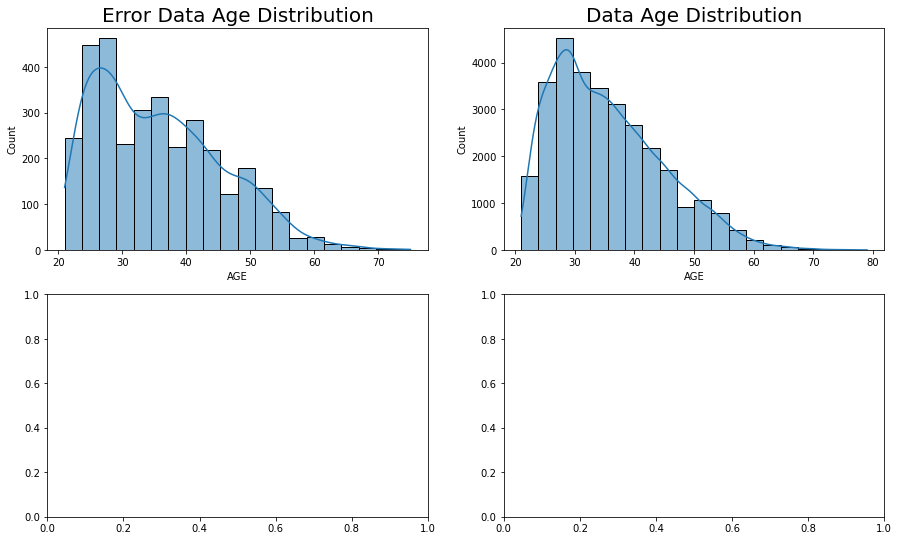

In [44]:
# Plots a comparison between the distribution of age variable in the original 
# dataset and the error dataset

fig, axes = plt.subplots(2,2, figsize=(15,9))
ax1 = sns.histplot(data=data_error_frame, x='AGE', kde=True, bins=20, ax=axes[0][0])
ax2 = sns.histplot(data=data, x='AGE', kde=True, bins=20, ax=axes[0][1])
ax1.set_title('Error Data Age Distribution', fontsize=20)
ax2.set_title('Data Age Distribution', fontsize=20)

In [45]:
# Prints the age_binned variable rates
data_error_frame['AGE_BINNED'].value_counts(normalize=True)

21-31    0.410570
31-41    0.312929
41-51    0.201553
51-61    0.065691
61-71    0.008361
71-81    0.000896
Name: AGE_BINNED, dtype: float64

So far, the examination shows percentages similar to the general ones, although in the age distribution it is appreciated that in some small age ranges more errors occur than in others. Even so, in the ten-year intervals created, the percentages are still quite similar.

Before continuing with the analysis of the errors, a new dataframe is created, this time only with the false negatives, that is, with those errors that mean predicting a not default that is actually a default. Since in reality this type of error interests us a little more to detect:

&nbsp;

In [46]:
# Using loc creates a new Dataframe  with the rows that have a false negative error concretely 
error_frame2 = test_frame.loc[(test_frame['DEF_PAY_default']==1)&(test_frame['preds']==0)]

In [47]:
# Take the indices of this Dataframe since the ones that came from y_test are kept,
# which are those of the original dataset
index_list2 = error_frame2.index

In [48]:
# Using iloc create a dataframe from the original containing the rows that have been 
# wrongly predicted
data_error_frame2 = data.iloc[index_list2]

In [49]:
# Information about the Dataframe
data_error_frame2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 16900 to 7716
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   ID                         910 non-null    int64   
 1   LIMIT_BAL                  910 non-null    int64   
 2   MARRIAGE                   910 non-null    int64   
 3   AGE                        910 non-null    int64   
 4   SEP_PAY1                   910 non-null    int64   
 5   AUG_PAY2                   910 non-null    int64   
 6   JUL_PAY3                   910 non-null    int64   
 7   JUN_PAY4                   910 non-null    int64   
 8   MAY_PAY5                   910 non-null    int64   
 9   APR_PAY6                   910 non-null    int64   
 10  SEP_BILL1                  910 non-null    int64   
 11  AUG_BILL2                  910 non-null    int64   
 12  JUL_BILL3                  910 non-null    int64   
 13  JUN_BILL4                  910

In [50]:
# Prints the female/male rates of the error frame
data_error_frame2['SEX_female'].value_counts(normalize=True)

1    0.657143
0    0.342857
Name: SEX_female, dtype: float64

In [51]:
# Prints the Education_university variable rates
data_error_frame2['EDUCATION_university'].value_counts(normalize=True)

0    0.557143
1    0.442857
Name: EDUCATION_university, dtype: float64

In [52]:
# Prints the marriage variable rates
data_error_frame2['MARRIAGE'].value_counts(normalize=True)

2    0.510989
1    0.479121
3    0.008791
0    0.001099
Name: MARRIAGE, dtype: float64

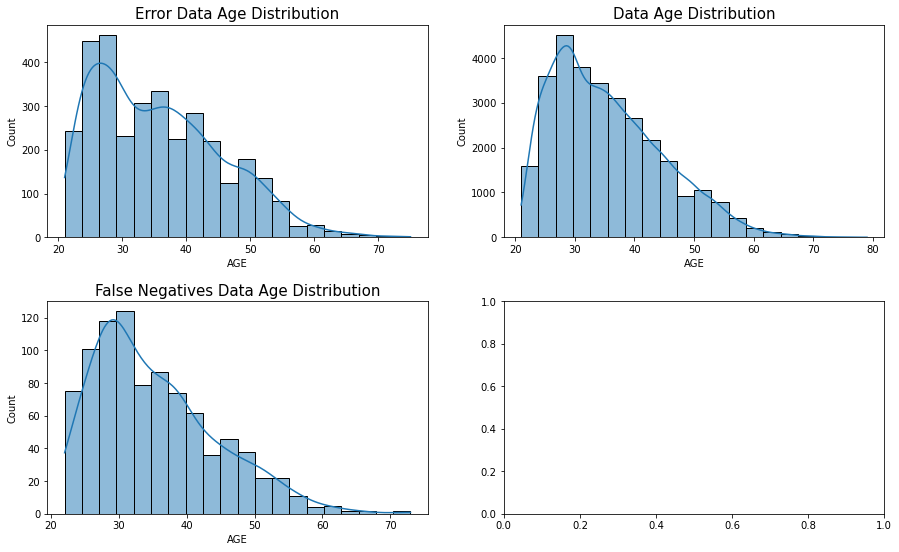

In [53]:
# Plots a comparison between the distribution of age variable in the original 
# dataset, the error dataset and the false negatives data set
fig, axes = plt.subplots(2,2, figsize=(15,9))
ax1 = sns.histplot(data=data_error_frame, x='AGE', kde=True, bins=20, ax=axes[0][0])
ax2 = sns.histplot(data=data, x='AGE', kde=True, bins=20, ax=axes[0][1])
ax3 = sns.histplot(data=data_error_frame2, x='AGE', kde=True, bins=20, ax=axes[1][0])
ax1.set_title('Error Data Age Distribution', fontsize=15)
ax2.set_title('Data Age Distribution', fontsize=15)
ax3.set_title('False Negatives Data Age Distribution', fontsize=15)
plt.subplots_adjust(hspace = 0.3)

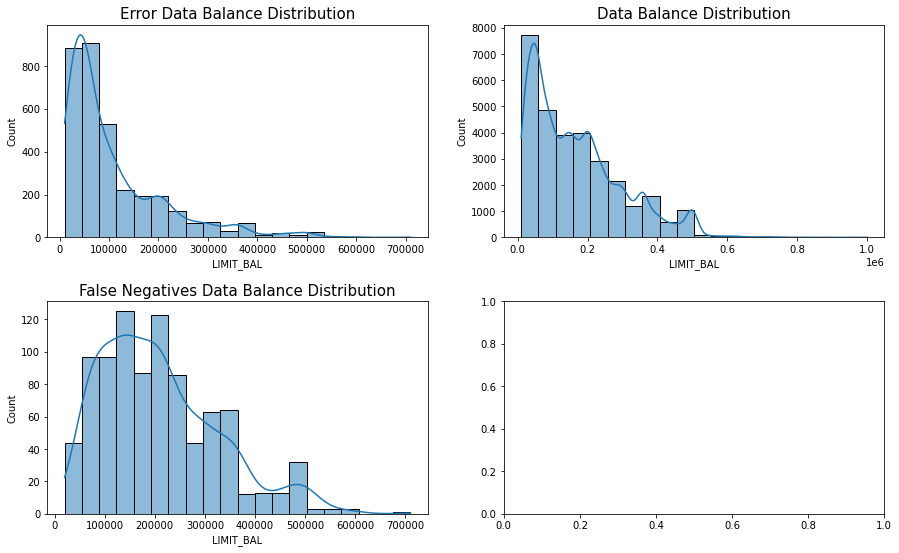

In [54]:
# Plots a comparison between the distribution of Limit Balance variable in the original 
# dataset, the error dataset and the false negatives data set
fig, axes = plt.subplots(2,2, figsize=(15,9))
ax1 = sns.histplot(data=data_error_frame, x='LIMIT_BAL', kde=True, bins=20, ax=axes[0][0])
ax2 = sns.histplot(data=data, x='LIMIT_BAL', kde=True, bins=20, ax=axes[0][1])
ax3 = sns.histplot(data=data_error_frame2, x='LIMIT_BAL', kde=True, bins=20, ax=axes[1][0])
ax1.set_title('Error Data Balance Distribution', fontsize=15)
ax2.set_title('Data Balance Distribution', fontsize=15)
ax3.set_title('False Negatives Data Balance Distribution', fontsize=15)
plt.subplots_adjust(hspace = 0.3)

Comparing the distribution of the Limit Balance variable, the most important for the model, a couple of questions appear:
- The largest error rate is concentrated in the smallest Limit Balance intervals.
- Although in the error dataset it seems that the highest concentration is in the second interval, that is (50.000-100.000], in the false negatives it is mainly concentrated in the first one (5.000-50.000].

Taking this information into account and the fact that the first interval -(5,000-50,000]- is the one with the highest default rate and the one that represents a larger number of clients, the next step will try to establish a model for this first interval and another for the rest of the dataset.

### Building two models<a class='anchor' id='two'></a>

&nbsp;

In [55]:
# Creates a new dataframe using loc and Limit Balance variable
data2 = data.loc[data['LIMIT_BAL']<=50000]

In [56]:
# Shows the not/defaul rates of the dataframe
np.round(data2['DEF_PAY_default'].value_counts(normalize=True)*100,decimals=2)

0    68.22
1    31.78
Name: DEF_PAY_default, dtype: float64

In [57]:
# Selecting features
X = data2[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data2['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.08, n_estimators=401, max_depth=15, min_samples_split=100,min_samples_leaf=1000, max_features=2,random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data2,0.28)

              precision    recall  f1-score   support

           0       0.73      0.38      0.50      1557
           1       0.36      0.71      0.48       764

    accuracy                           0.49      2321
   macro avg       0.54      0.55      0.49      2321
weighted avg       0.61      0.49      0.49      2321

     pred_neg  pred_pos
neg       599       958
pos       225       539 

Actual positives in the data set:32.9%
Marked as positive by the algorithm:64.5%
Actual positives inside the marked as positive: 36.0%
Currently missed positives of the total actual positives: 29.5

The final default rate after applying this algorithm could be: 9.7%
The number of customers would be reduced in comparison to the current number to a 35.5%


&nbsp;

The objective in this model is to greatly reduce the default percentage and keep a third of the customers approx. As mentioned above, this is an interval where many clients accumulate and with an especially high default rate, so it is key that the recall is high in this model.
As mentioned above, this is an interval where many clients accumulate and with an especially high default rate, so it is key that the recall is high in this model. In this case, 0.71 has been obtained at the cost of losing 64.5% of the customers in this interval. 

To observe the consequences of using a prediction model strategy or another on all our clients, we store in a dataframe those that are accepted by the model:

&nbsp;

In [58]:
# Uses the function created previously which is nested in the "classification_matrix_report"
#function to get the array of predictions with the desired threshold
preds = adjusted_classes(y_scores, 0.28)

# Converts y_test to DataFrame type
test_frame = Series.to_frame(y_test)

# Insert the array containing the predictions made by the function in the DataFrame 
# with the actual results created previously
test_frame.insert(1,'preds',preds)

# Using loc creates a new dataframe  with the rows that have 'preds' column equal to 0, that is, 
# negative class or not default
accepted_data = test_frame.loc[test_frame['preds']==0]

# Take the indices of this Dataframe since the ones that came from y_test are kept,
# which are those of the original dataset
index_list = accepted_data.index

# Using iloc create a dataframe from the original containing the rows that have been 
# well predicted
df2 = data.iloc[index_list]

&nbsp;

Now a model is built for the rest of the dataset :

&nbsp;

In [59]:
# Creates a new dataframe using loc and Limit Balance variable
data3 = data.loc[data['LIMIT_BAL']>50000]

In [60]:
# Shows the not default/default rates of the dataframe
np.round(data3['DEF_PAY_default'].value_counts(normalize=True)*100,decimals=2)

0    81.2
1    18.8
Name: DEF_PAY_default, dtype: float64

In [61]:
# Selecting features
X = data3[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data3['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.07, n_estimators=201, max_depth=5, min_samples_split=100,min_samples_leaf=2500, max_features=2,random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data3,0.24)

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      5487
           1       0.28      0.34      0.31      1254

    accuracy                           0.71      6741
   macro avg       0.56      0.57      0.56      6741
weighted avg       0.74      0.71      0.72      6741

     pred_neg  pred_pos
neg      4381      1106
pos       828       426 

Actual positives in the data set:18.6%
Marked as positive by the algorithm:22.7%
Actual positives inside the marked as positive: 27.8%
Currently missed positives of the total actual positives: 66.0

The final default rate after applying this algorithm could be: 12.3%
The number of customers would be reduced in comparison to the current number to a 77.3%


&nbsp;

For this model, the objective is to preserve a large part of the current customer volume but lowering the default rate as much as possible. Thus we see how the precision and recall metrics for the positive class are lower, especially the recall, and vice versa, the metrics for the negative class are much higher than in the previous model.

And again, to observe the consequences of using a prediction model strategy or another on all our clients, we store in a dataframe those that are accepted by the model:


&nbsp;

In [62]:
# Uses the function created previously which is nested in the "classification_matrix_report"
#function to get the array of predictions with the desired threshold
preds = adjusted_classes(y_scores, 0.24)

# Converts y_test to dataframe type
test_frame = Series.to_frame(y_test)

# Insert the array containing the predictions made by the function in the DataFrame 
# with the actual results created previously
test_frame.insert(1,'preds',preds)

# Using loc creates a new dataframe  with the rows that have 'preds' column equal to 0, that is, 
# negative class or not default
accepted_data = test_frame.loc[test_frame['preds']==0]


# Take the indices of this Dataframe since the ones that came from y_test are kept,
# which are those of the original dataset
index_list = accepted_data.index

# Using iloc create a dataframe from the original containing the rows that have been 
# well predicted
df3 = data.iloc[index_list]

&nbsp;

Once the two models have been built, to see what results achieve, it is calculated what is the general default rate and volume of total clients:

&nbsp;

In [63]:
# Extracts the percentage of customers that would remain in the data2 & data3 models
# with the global variables data2_perc & data3_perc nested in the "classification_matrix_report"
# function and calculates how many rows there are
total2 = ((len(data2)*data2_perc)/100)
total3 = ((len(data3)*data3_perc)/100)

# Extracts the percentage that these rows represent of the total data set
total2_perc = (total2/len(data))*100
total3_perc = (total3/len(data))*100

# Creates a weighted average of the default rates in each model 
perc2 = final_def_perc2*total2_perc
perc3 = final_def_perc3*total3_perc
final_default_rate = (perc2+perc3)/(total2_perc+total3_perc)

# Prints de final default rate and percentage of customers 
print('Final default rate is {}%'.format(np.round(final_default_rate,decimals=2)))
print('Number of clients remaining is {}%'.format(np.round(((total2+total3)/len(data))*100,decimals=2)))

Final default rate is 11.95%
Number of clients remaining is 66.6%


&nbsp;

These results are not very far from the results obtained with a single model. If with a single model it was possible to obtain around 10% with approximately 60% of the clients, it seems reasonable that by modifying the treshold a little and fine-tuning the model, the same results can be achieved using two models and vice versa.

Even so, it would be interesting to see what percentages of clients each interval would represent with each of the strategies:

&nbsp;

In [64]:
# Concatenates df df2
well_pred_data = pd.concat([df2,df3])

In [65]:
# Creates a new column by binning the Limit Balance variable
well_pred_data['BAL_BINNED'] = pd.cut(well_pred_data['LIMIT_BAL'], bins=[5000,50000,100000,150000,200000,250000,300000,400000,500000,1000000],
labels=['(5000, 50000]','(50000, 100000]','(100000, 150000]',
        '(150000, 200000]','(250000, 300000]','(200000, 250000]',
        '(300000, 400000]','(400000, 500000]', ('+500000')])

In [66]:
# Creates the percentages of each interval of the BAL_BINNED variable for the well pred dataframe
bal_percs = np.round((well_pred_data['BAL_BINNED'].value_counts(normalize=True))*100,decimals=1)

# Creates the percentages of each interval of the BAL_BINNED variable for the general dataframe
bal_percs_data = np.round(df['BAL_BINNED'].value_counts(normalize=True)*100,decimals=2)

#Prints the percentages
print(bal_percs,'\n',bal_percs_data)

(150000, 200000]    18.1
(250000, 300000]    15.0
(300000, 400000]    14.0
(100000, 150000]    13.9
(5000, 50000]       13.7
(200000, 250000]    11.2
(400000, 500000]     7.9
(50000, 100000]      5.3
+500000              0.9
Name: BAL_BINNED, dtype: float64 
 (150000, 200000]    19.48
(100000, 150000]    15.01
(300000, 400000]    14.96
(250000, 300000]    14.36
(50000, 100000]     11.70
(200000, 250000]    11.39
(400000, 500000]     8.31
(5000, 50000]        3.60
+500000              1.19
Name: BAL_BINNED, dtype: float64


Looking at the percentages, it is observed that:

- The strategy of implementing a single model what it really does is destroy the first interval -(5,000-50,000]-, which we remember that before it represented 25.6% and now a scarce 3.6%.
- By implementing two different models, what is achieved is to soften the influence exerted by the first interval on the total results without making it disappear almost completely.

Finally, an attempt is made to build a model for each Limit Balance interval to see if the final result can be further optimized.

&nbsp;

### Building a model for each interval<a class='anchor' id='each'></a>

&nbsp;

In [67]:
# Creates a new dataframe using loc and Limit Balance variable
data2 = data.loc[data['LIMIT_BAL']<=50000]

In [68]:
# Shows the not/defaul rates of the dataframe
np.round(data2['DEF_PAY_default'].value_counts(normalize=True)*100,decimals=2)

0    68.22
1    31.78
Name: DEF_PAY_default, dtype: float64

In [69]:
# Selecting features
X = data2[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data2['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.19, n_estimators=101, max_depth=8, min_samples_split=100,min_samples_leaf=100, max_features=2,random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data2,0.33)

              precision    recall  f1-score   support

           0       0.69      0.57      0.62      1557
           1       0.35      0.48      0.40       764

    accuracy                           0.54      2321
   macro avg       0.52      0.52      0.51      2321
weighted avg       0.58      0.54      0.55      2321

     pred_neg  pred_pos
neg       881       676
pos       399       365 

Actual positives in the data set:32.9%
Marked as positive by the algorithm:44.9%
Actual positives inside the marked as positive: 35.1%
Currently missed positives of the total actual positives: 52.2

The final default rate after applying this algorithm could be: 17.2%
The number of customers would be reduced in comparison to the current number to a 55.1%


In [70]:
# Uses the function created previously which is nested in the "classification_matrix_report"
#function to get the array of predictions with the desired threshold
preds = adjusted_classes(y_scores, 0.33)

# Converts y_test to dataframe type
test_frame = Series.to_frame(y_test)

# Insert the array containing the predictions made by the function in the DataFrame 
# with the actual results created previously
test_frame.insert(1,'preds',preds)


# Using loc creates a new dataframe  with the rows that have 'preds' column equal to 0, that is, 
# negative class or not default
accepted_data = test_frame.loc[test_frame['preds']==0]


# Take the indices of this Dataframe since the ones that came from y_test are kept,
# which are those of the original dataset
index_list = accepted_data.index

# Using iloc create a dataframe from the original containing the rows that have been 
# well predicted
df4 = data.iloc[index_list]

In [71]:
# Creates a new dataframe using loc and Limit Balance variable
data3 = data.loc[(data['LIMIT_BAL']>50000)&(data['LIMIT_BAL']<=100000)]

In [72]:
# Shows the not/defaul rates of the dataframe
data3['DEF_PAY_default'].value_counts(normalize=True)

0    0.741969
1    0.258031
Name: DEF_PAY_default, dtype: float64

In [73]:
# Selecting features
X = data3[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data3['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.09, n_estimators=201, max_depth=5, min_samples_split=100,min_samples_leaf=500, max_features='sqrt',random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data3,0.28)

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1069
           1       0.32      0.41      0.36       388

    accuracy                           0.61      1457
   macro avg       0.54      0.55      0.54      1457
weighted avg       0.64      0.61      0.62      1457

     pred_neg  pred_pos
neg       725       344
pos       228       160 

Actual positives in the data set:26.6%
Marked as positive by the algorithm:34.6%
Actual positives inside the marked as positive: 31.7%
Currently missed positives of the total actual positives: 58.8

The final default rate after applying this algorithm could be: 15.6%
The number of customers would be reduced in comparison to the current number to a 65.4%


In [74]:
# Uses the function created previously which is nested in the "classification_matrix_report"
#function to get the array of predictions with the desired threshold
preds = adjusted_classes(y_scores, 0.28)

# Converts y_test to dataframe type
test_frame = Series.to_frame(y_test)

# Insert the array containing the predictions made by the function in the DataFrame 
# with the actual results created previously
test_frame.insert(1,'preds',preds)

# Using loc creates a new dataframe  with the rows that have 'preds' column equal to 0, that is, 
# negative class or not default
accepted_data = test_frame.loc[test_frame['preds']==0]


# Take the indices of this Dataframe since the ones that came from y_test are kept,
# which are those of the original dataset
index_list = accepted_data.index

# Using iloc create a dataframe from the original containing the rows that have been 
# well predicted
df5 = data.iloc[index_list]

In [75]:
# Creates a new dataframe using loc and Limit Balance variable
data4 = data.loc[(data['LIMIT_BAL']>100000)&(data['LIMIT_BAL']<=150000)]

In [76]:
# Shows the not/defaul rates of the dataframe
data4['DEF_PAY_default'].value_counts(normalize=True)

0    0.788682
1    0.211318
Name: DEF_PAY_default, dtype: float64

In [77]:
# Selecting features
X = data4[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data4['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.09, n_estimators=151, max_depth=3, min_samples_split=100,min_samples_leaf=500, max_features=2,random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data4,0.225)

              precision    recall  f1-score   support

           0       0.81      0.67      0.73       935
           1       0.24      0.41      0.30       242

    accuracy                           0.61      1177
   macro avg       0.53      0.54      0.52      1177
weighted avg       0.70      0.61      0.64      1177

     pred_neg  pred_pos
neg       623       312
pos       143        99 

Actual positives in the data set:20.6%
Marked as positive by the algorithm:34.9%
Actual positives inside the marked as positive: 24.1%
Currently missed positives of the total actual positives: 59.1

The final default rate after applying this algorithm could be: 12.1%
The number of customers would be reduced in comparison to the current number to a 65.1%


In [78]:
# Uses the function created previously which is nested in the "classification_matrix_report"
#function to get the array of predictions with the desired threshold
preds = adjusted_classes(y_scores, 0.225)

# Converts y_test to dataframe type
test_frame = Series.to_frame(y_test)

# Insert the array containing the predictions made by the function in the DataFrame 
# with the actual results created previously
test_frame.insert(1,'preds',preds)

# Using loc creates a new dataframe  with the rows that have 'preds' column equal to 0, that is, 
# negative class or not default
accepted_data = test_frame.loc[test_frame['preds']==0]


# Take the indices of this Dataframe since the ones that came from y_test are kept,
# which are those of the original dataset
index_list = accepted_data.index

# Using iloc create a dataframe from the original containing the rows that have been 
# well predicted
df6 = data.iloc[index_list]

In [79]:
# Creates a new dataframe using loc and Limit Balance variable
data5 = data.loc[(data['LIMIT_BAL']>150000)&(data['LIMIT_BAL']<=200000)]

In [80]:
# Shows the not/defaul rates of the dataframe
data5['DEF_PAY_default'].value_counts(normalize=True)

0    0.821384
1    0.178616
Name: DEF_PAY_default, dtype: float64

In [81]:
# Selecting features
X = data5[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data5['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.09, n_estimators=201, max_depth=4, min_samples_split=100,min_samples_leaf=100, max_features=2,random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data5,0.19)

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       979
           1       0.21      0.39      0.28       222

    accuracy                           0.62      1201
   macro avg       0.52      0.53      0.51      1201
weighted avg       0.72      0.62      0.66      1201

     pred_neg  pred_pos
neg       663       316
pos       136        86 

Actual positives in the data set:18.5%
Marked as positive by the algorithm:33.5%
Actual positives inside the marked as positive: 21.4%
Currently missed positives of the total actual positives: 61.3

The final default rate after applying this algorithm could be: 11.3%
The number of customers would be reduced in comparison to the current number to a 66.5%


In [82]:
# Uses the function created previously which is nested in the "classification_matrix_report"
#function to get the array of predictions with the desired threshold
preds = adjusted_classes(y_scores, 0.19)

# Converts y_test to dataframe type
test_frame = Series.to_frame(y_test)

# Insert the array containing the predictions made by the function in the DataFrame 
# with the actual results created previously
test_frame.insert(1,'preds',preds)

# Using loc creates a new dataframe  with the rows that have 'preds' column equal to 0, that is, 
# negative class or not default
accepted_data = test_frame.loc[test_frame['preds']==0]


# Take the indices of this Dataframe since the ones that came from y_test are kept,
# which are those of the original dataset
index_list = accepted_data.index

# Using iloc create a dataframe from the original containing the rows that have been 
# well predicted
df7 = data.iloc[index_list]

In [83]:
# Creates a new dataframe using loc and Limit Balance variable
data6 = data.loc[data['LIMIT_BAL']>200000]

In [84]:
# Shows the not/defaul rates of the dataframe
data6['DEF_PAY_default'].value_counts(normalize=True)

0    0.852659
1    0.147341
Name: DEF_PAY_default, dtype: float64

In [85]:
# Selecting features
X = data6[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data6['DEF_PAY_default']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = GradientBoostingClassifier(learning_rate=0.04, n_estimators=501, max_depth=15, min_samples_split=100,min_samples_leaf=100, max_features=2,random_state=10)
model = algo.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:,1]

# Calls the function
classification_matrix_report(data6,0.18)

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      2486
           1       0.18      0.36      0.24       420

    accuracy                           0.67      2906
   macro avg       0.53      0.54      0.52      2906
weighted avg       0.77      0.67      0.71      2906

     pred_neg  pred_pos
neg      1797       689
pos       268       152 

Actual positives in the data set:14.5%
Marked as positive by the algorithm:28.9%
Actual positives inside the marked as positive: 18.1%
Currently missed positives of the total actual positives: 63.8

The final default rate after applying this algorithm could be: 9.2%
The number of customers would be reduced in comparison to the current number to a 71.1%


In [86]:
# Uses the function created previously which is nested in the "classification_matrix_report"
#function to get the array of predictions with the desired threshold
preds = adjusted_classes(y_scores, 0.18)

# Converts y_test to dataframe type
test_frame = Series.to_frame(y_test)

# Insert the array containing the predictions made by the function in the DataFrame 
# with the actual results created previously
test_frame.insert(1,'preds',preds)

# Using loc creates a new dataframe  with the rows that have 'preds' column equal to 0, that is, 
# negative class or not default
accepted_data = test_frame.loc[test_frame['preds']==0]


# Take the indices of this Dataframe since the ones that came from y_test are kept,
# which are those of the original dataset
index_list = accepted_data.index

# Using iloc create a dataframe from the original containing the rows that have been 
# well predicted
df8 = data.iloc[index_list]

In [87]:
# Extracts the percentage of customers that would remain from data2 to data6 models
# with the global variables from data2_perc to data6_perc nested in the "classification_matrix_report"
# function and calculates how many rows there are
total2 = ((len(data2)*data2_perc)/100)
total3 = ((len(data3)*data3_perc)/100)
total4 = ((len(data4)*data4_perc)/100)
total5 = ((len(data5)*data5_perc)/100)
total6 = ((len(data6)*data6_perc)/100)

# Extracts the percentage that these rows represent of the total data set
total2_perc = (total2/len(data))*100
total3_perc = (total3/len(data))*100
total4_perc = (total4/len(data))*100
total5_perc = (total5/len(data))*100
total6_perc = (total6/len(data))*100

# Creates a weighted average of the default rates in each model 
perc2 = final_def_perc2*total2_perc
perc3 = final_def_perc3*total3_perc
perc4 = final_def_perc4*total4_perc
perc5 = final_def_perc5*total5_perc
perc6 = final_def_perc6*total6_perc
final_default_rate = (perc2+perc3+perc4+perc5+perc6)/(total2_perc+total3_perc+total4_perc+total5_perc+total6_perc)

# Prints de final default rate and percentage of customers 
print('Final default rate is {}%'.format(np.round(final_default_rate,decimals=2)))
print('Number of clients remaining is {}%'.format(np.round(((total2+total3+total4+total5+total6)/len(data))*100,decimals=2)))

Final default rate is 12.65%
Number of clients remaining is 64.7%


&nbsp;

Now we can compare the results obtained in the different three strategies: 

- One model: 10% default rate / 61.2% clients remaining
- Two models: 11.95% / 66.6% clients remaining
- One model for each interval: 12.65% / 64.7% clients remaining

Beyond the fact that until now a specific element of comparison has not been established, -default rate or customers remaining- it seems that the strategy of establishing a model for each interval does not give better results than establishing two models since it can be seen how it obtains a percentage higher default and with fewer clients remaining.

&nbsp;

In [88]:
# Concatenates from df4 to df8
well_pred_data2 = pd.concat([df4,df5,df6,df7,df8])

In [89]:
# Creates a new column by binning the Limit Balance variable
well_pred_data2['BAL_BINNED'] = pd.cut(well_pred_data2['LIMIT_BAL'], bins=[5000,50000,100000,150000,200000,250000,300000,400000,500000,1000000],
labels=['(5000, 50000]','(50000, 100000]','(100000, 150000]',
        '(150000, 200000]','(250000, 300000]','(200000, 250000]',
        '(300000, 400000]','(400000, 500000]', ('+500000')])

In [90]:
# Creates the percentages of each interval of the BAL_BINNED variable for the well_pred_data2 dataframe
bal_percs2 = np.round((well_pred_data2['BAL_BINNED'].value_counts(normalize=True))*100,decimals=1)

# Prints the percentages
print(bal_percs2,'\n',bal_percs,'\n',bal_percs_data)

(5000, 50000]       21.8
(50000, 100000]     16.3
(150000, 200000]    13.6
(100000, 150000]    13.1
(300000, 400000]    10.7
(250000, 300000]     9.9
(200000, 250000]     7.3
(400000, 500000]     6.6
+500000              0.7
Name: BAL_BINNED, dtype: float64 
 (150000, 200000]    18.1
(250000, 300000]    15.0
(300000, 400000]    14.0
(100000, 150000]    13.9
(5000, 50000]       13.7
(200000, 250000]    11.2
(400000, 500000]     7.9
(50000, 100000]      5.3
+500000              0.9
Name: BAL_BINNED, dtype: float64 
 (150000, 200000]    19.48
(100000, 150000]    15.01
(300000, 400000]    14.96
(250000, 300000]    14.36
(50000, 100000]     11.70
(200000, 250000]    11.39
(400000, 500000]     8.31
(5000, 50000]        3.60
+500000              1.19
Name: BAL_BINNED, dtype: float64


If we look again at the weight of each interval after applying the different strategies, we see :
- The first section represents the strategy of different models.
- The second section represents the strategy of two models. 
- The third section represents the strategy of one model.


- The first strategy does not diminish the influence of the first interval much, this is because it has been decided not to tighten the model too much so as not to lower the number of customers even more.
- Como se ha mencionado anteriormente la segunda estrategia disminuye más la influencia del primer intervalo y consigue mejores resultados.

- La tercera estrategia consigue unos resultados parecidos a la segunda però elimina casi por completo el primer intervalo.




&nbsp;

In [91]:
rev_cust = data[['SEP_PAY1','AUG_PAY2','JUL_PAY3','JUN_PAY4','MAY_PAY5','APR_PAY6']]
index_list = rev_cust.loc[(rev_cust.max(axis=1)==0)&(rev_cust.min(axis=1)==-1)].index
data['GOOD_CUST'] = 0 
data['GOOD_CUST'].loc[index_list] = 1




/Users/albert/opt/anaconda3/envs/understanding-customers/lib/python3.9/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [92]:
data.loc[data['GOOD_CUST']==1]

,ID,LIMIT_BAL,MARRIAGE,AGE,SEP_PAY1,AUG_PAY2,JUL_PAY3,JUN_PAY4,MAY_PAY5,APR_PAY6,...,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,DEF_PAY_default,DEF_PAY_not default,AGE_BINNED,BAL_BINNED,BAL_DIF,GOOD_CUST
4,5,50000,1,57,-1,0,-1,0,0,0,...,0,0,0,1,0,1,51-61,"(5000, 50000]",-14165,1
7,8,100000,2,23,0,-1,-1,0,0,-1,...,0,0,0,1,0,1,21-31,"(50000, 100000]",-88124,1
12,13,630000,2,41,-1,0,-1,-1,-1,-1,...,0,0,0,1,0,1,31-41,+500000,-617863,1
17,18,320000,1,49,0,0,0,-1,-1,-1,...,1,0,0,0,0,1,41-51,"(300000, 400000]",-66714,1
20,21,130000,2,39,0,0,0,0,0,-1,...,0,1,0,0,0,1,31-41,"(100000, 150000]",-91642,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30169,29969,20000,2,34,0,0,0,0,0,-1,...,0,0,0,1,0,1,31-41,"(5000, 50000]",-3022,1
30171,29971,360000,1,34,-1,-1,-1,0,0,-1,...,1,0,0,0,0,1,31-41,"(300000, 400000]",-295931,1
30173,29973,190000,1,37,0,0,0,0,0,-1,...,1,0,0,0,0,1,31-41,"(150000, 200000]",-41518,1
30194,29994,100000,2,38,0,-1,-1,0,0,0,...,1,0,0,0,0,1,31-41,"(50000, 100000]",2996,1


In [93]:
# Selecting features
X = data[['AGE','LIMIT_BAL','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school']]

# Selecting dependent variable
y = data['GOOD_CUST']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=125)

# Modelling(Classification)
algo = RandomForestClassifier()
model = algo.fit(X_train, y_train)
preds = model.predict(X_test)

df = pd.DataFrame(confusion_matrix(y_test, preds),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos'])
# Calls the function
print(classification_report(y_test, preds))
print(df)

              precision    recall  f1-score   support

           0       0.88      0.97      0.93      7977
           1       0.16      0.04      0.06      1084

    accuracy                           0.86      9061
   macro avg       0.52      0.51      0.49      9061
weighted avg       0.80      0.86      0.82      9061

     pred_neg  pred_pos
neg      7774       203
pos      1045        39


## Regression<a class='anchor' id='regression'></a>

As explained in the introduction, this section tries to understand which quantity is the most suitable for each client through regression models. To begin with, three models are built -RandomForest Regressor, Linear Regression, Support Vector Regression- to find the most appropriate model. To do this, cross validation is used for the three models :

&nbsp;

In [94]:
# Shows the first 20 lines of the dataframe
data[:20]

,ID,LIMIT_BAL,MARRIAGE,AGE,SEP_PAY1,AUG_PAY2,JUL_PAY3,JUN_PAY4,MAY_PAY5,APR_PAY6,...,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,DEF_PAY_default,DEF_PAY_not default,AGE_BINNED,BAL_BINNED,BAL_DIF,GOOD_CUST
0,1,20000,1,24,2,2,-1,-1,-2,-2,...,0,0,0,1,1,0,21-31,"(5000, 50000]",-16087,0
1,2,120000,2,26,-1,2,0,0,0,2,...,0,0,0,1,1,0,21-31,"(100000, 150000]",-116545,0
2,3,90000,2,34,0,0,0,0,0,0,...,0,0,0,1,0,1,31-41,"(50000, 100000]",-60761,0
3,4,50000,1,37,0,0,0,0,0,0,...,0,0,0,1,0,1,31-41,"(5000, 50000]",-709,0
4,5,50000,1,57,-1,0,-1,0,0,0,...,0,0,0,1,0,1,51-61,"(5000, 50000]",-14165,1
5,6,50000,2,37,0,0,0,0,0,0,...,1,0,0,0,0,1,31-41,"(5000, 50000]",14400,0
6,7,500000,2,29,0,0,0,0,0,0,...,1,0,0,0,0,1,21-31,"(400000, 500000]",42653,0
7,8,100000,2,23,0,-1,-1,0,0,-1,...,0,0,0,1,0,1,21-31,"(50000, 100000]",-88124,1
8,9,140000,1,28,0,0,2,0,0,0,...,0,1,0,0,0,1,21-31,"(100000, 150000]",-125904,0
9,10,20000,2,35,-2,-2,-2,-2,-1,-1,...,0,1,0,0,0,1,31-41,"(5000, 50000]",-6088,0


In [95]:
# Selecting features
X = data[['AGE','DEF_PAY_default','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_university', 'EDUCATION_high school','EDUCATION_other']]


In [96]:
# Selecting dependent variable
y = data['LIMIT_BAL']

In [97]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=129)

In [98]:
# Creates an array of models
algosClass = []
algosClass.append(('Random Forest Regressor',RandomForestRegressor()))
algosClass.append(('Linear Regression',LinearRegression(normalize=True)))
algosClass.append(('Support Vector Regression',SVR()))

In [99]:
# Loops across the array and uses the cross_val_score function for each model
results = []
names = []
for name, model in algosClass:
    result = cross_val_score(model, X,y, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

# Prints the results of each model
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 0.17531880836458755
Linear Regression 0.1228458465800056
Support Vector Regression -0.055216606238931286


&nbsp;

Taking into account that Random Forest gives the best result, we invoke it again and begin to analyze the variables included in the model:

&nbsp;

In [100]:
# Selecting features
X = data[['AGE','SEX_male', 'EDUCATION_graduate school', 'EDUCATION_high school']]

# Selecting dependent variable
y = data['LIMIT_BAL']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=129)

# Modelling(Regression)
algo = RandomForestRegressor()
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, preds))
predRsquared = r2_score(y_test,preds)

print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)



R Squared: 0.183
RMSE: 116951.453


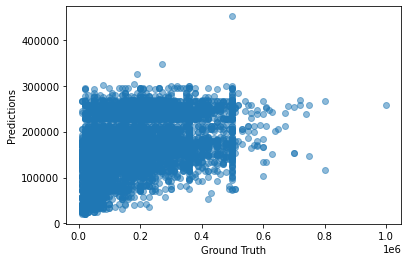

In [101]:
# Plots a comparison between the known values and the preds
plt.scatter(y_test, preds,alpha=0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show();

In [102]:
# Creates a sample of the dataframe
sample = data.sample(n=1000)

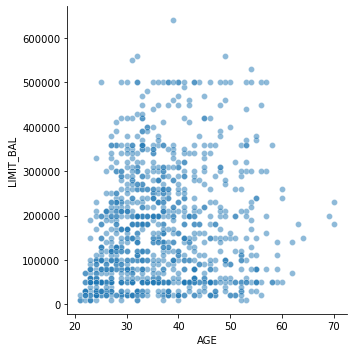

In [103]:
# Scatterplot takin AGE as x variable and LIMIT_BAL as y variable
sns.relplot(x='AGE',y='LIMIT_BAL',data=sample,alpha=0.5)

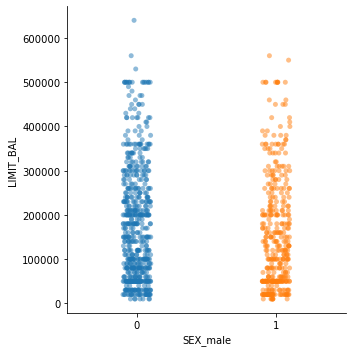

In [104]:
# Scatterplot taking categorical SEX_male as x variable and continuous LIMIT_BAL as y variable 
sns.catplot(x='SEX_male',y='LIMIT_BAL',data=sample,alpha=0.5)

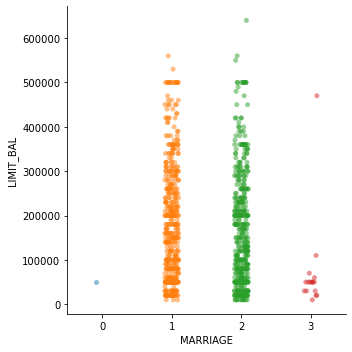

In [105]:
# Scatterplot taking categorical MARRIAGE as x variable and continuous LIMIT_BAL as y variable 
sns.catplot(x='MARRIAGE',y='LIMIT_BAL',data=sample,alpha=0.5)

## Conclusions<a class='anchor' id='conclusions'></a>

Throughout the report, different conclusions have been reached so this section serves as a summary to understand them all together:

- For this type of business it is important to establish models as accurately as possible. Even so, in this specific case, it should be noted that we find a particularly high default rate, 22.7%. And with the data set we have, the positive class, that is, the defaults, cannot be predicted with much accuracy.


- For these reasons, it is necessary to take into account other metrics such as recall and precision and distinguish the performance of the model between the positive class -default- and the negative class -not default-. In this sense, a model that has good returns to predict not defaults is useless if it does not have them to predict defaults.


- In order to increase the recall for the positive class -default- it has been necessary to modify the threshold. That is, the probability limit from which the model considers a prediction as 1 -positive class- or 0 -negative class-.


- After making an analysis of the errors of the built model, it has been determined that the majority of errors came from the first Limit Balance interval (5.000-50.000].


- For this reason, it has been decided to test three different strategies:
  - Build a unique model.
  - Build two models (one for the first interval and one for the rest).
  - Build a model for each interval.
  

- The first two strategies have achieved better results than the third, but it seems that the most interesting would be the second since the first strategy -a single model- ends up completely eliminating the possibility of granting credits of between (5.000-50.000] while the second strategy is more balanced between all intervals.


- Regarding Regression, it has not yet been possible to achieve adequate results to understand what amount would be adequate for each client.